#### Chest X-Ray Images (Pneumonia)

URL: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [19]:
import os
import skimage
import numpy as np
from skimage.transform import resize
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [20]:
def get_shuffled_x_y(type_dataset, data_generator):
    train_normal_x, train_normal_y = get_x_y(type_dataset, 'NORMAL', data_generator)
    train_pneumonia_x, train_pneumonia_y = get_x_y(type_dataset, 'PNEUMONIA', data_generator)
    x = np.concatenate([train_normal_x, train_pneumonia_x])
    y = to_categorical(np.concatenate([train_normal_y, train_pneumonia_y]))
    shuffle = np.arange(x.shape[0])
    np.random.shuffle(shuffle)
    x = x[shuffle]
    y = y[shuffle]
    return x, y


In [21]:
def get_x_y(type_dataset, type_label, data_generator):
    x = []
    path = './datasets/' + type_dataset + "/" + type_label + "/"
    files = os.listdir(path)
    for file in files:
        if os.path.splitext(path + file)[1] == '.jpeg':
            img = np.array(Image.open(path + file))
            img = np.asarray(skimage.transform.resize(img, (150, 150, 3)))
            x.append(img)
    x = np.asarray(x)
    data_generator.fit(x)
    x = get_augmentate_x(x, data_generator)
    y = np.zeros(x.shape[0]) if type_label == 'NORMAL' else np.ones(x.shape[0])
    return x, y


In [22]:
def get_augmentate_x(x, data_generator):
    count = 0
    maxCount = x.shape[0]
    for x_batch in data_generator.flow(x, batch_size=12):
        x = np.concatenate([x, x_batch])
        count = count + x_batch.shape[0]
        if count >= maxCount:
            break;
    return x


In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def inverse_to_categorical(val):
    return np.argmax(val, axis=None, out=None)

def plot_confusion_matrix(predict_values, real_values):
    matrix = np.zeros([2, 2])
    for i in range(predict_values.shape[0]):
        true_y = inverse_to_categorical(real_values[i])
        predict_y = predict_values[i]
        matrix[true_y][predict_y] = matrix[true_y][predict_y] + 1
    
    df_cm = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, cmap="Blues", linewidths=0.1, linecolor='Black', square=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(matrix)


In [24]:
shift = 0.15

datagen_train = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

datagen_test = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

datagen_valid = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)


In [25]:
x_train, y_train = get_shuffled_x_y('train', datagen_train)

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [26]:
x_test, y_test = get_shuffled_x_y('test', datagen_test)

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [27]:
x_val, y_val = get_shuffled_x_y('val', datagen_valid)

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [28]:
print(x_train.shape)
print(y_train.shape)

(8200, 150, 150, 3)
(8200, 2)


In [29]:
print(x_test.shape)
print(x_test.shape)

(1758, 150, 150, 3)
(1758, 150, 150, 3)


In [30]:
print(x_val.shape)
print(y_val.shape)

(1756, 150, 150, 3)
(1756, 2)


In [31]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint

import sys
sys.path.insert(0, '../../Utils')
from fnn_helper import PlotLosses

In [32]:
dropout = 0.25

model = Sequential()
model.add(Convolution2D(filters=6, strides=1, kernel_size=6, padding='same',input_shape=(150,150,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Convolution2D(filters=12, strides=2, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Convolution2D(filters=24, strides=2, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 6)       654       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 6)       24        
_________________________________________________________________
activation_5 (Activation)    (None, 150, 150, 6)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 150, 150, 6)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 12)        1812      
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 12)        48        
_________________________________________________________________
activation_6 (Activation)    (None, 75, 75, 12)        0         
__________

In [33]:
lr = 0.0001
plot_interval = 1
epochs = 80
batch_size = 1024

adam = optimizers.Adam(lr=lr)
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

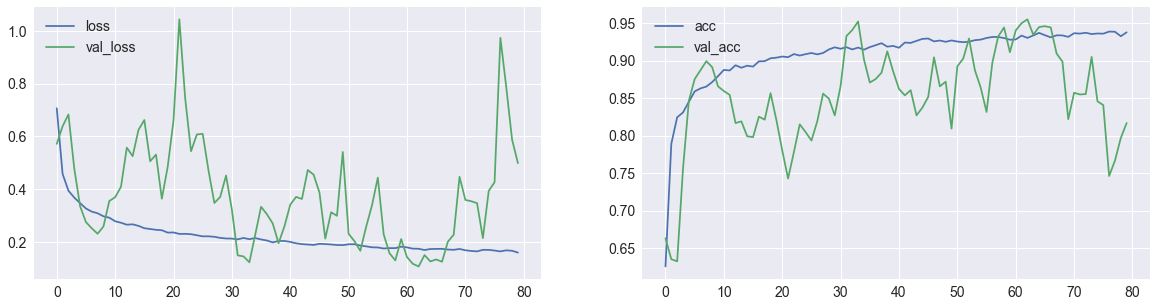


Epoch 00080: val_loss did not improve


In [34]:
checkpointer = ModelCheckpoint(filepath='Test3-ImgAugmentation.weights.best.hdf5', verbose=1, save_best_only=True)
plot_losses = PlotLosses(plot_interval=plot_interval, evaluate_interval=None, x_val=x_test, y_val_categorical=y_test)

model.fit(x_train, 
          y_train,
          epochs=epochs, 
          batch_size=batch_size, 
          #verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[plot_losses, 
                     checkpointer],
         )

In [35]:
model.load_weights('Test3-ImgAugmentation.weights.best.hdf5')
score = model.evaluate(x_val, y_val, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.13181277966988114
accuracy:  0.9470387246451236


[[ 405.   69.]
 [  24. 1258.]]


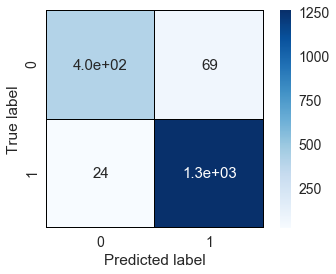

In [36]:
model.load_weights('Test3-ImgAugmentation.weights.best.hdf5')
plot_confusion_matrix(model.predict_classes(x_val), y_val)